In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')

In [16]:
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

In [18]:
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department','DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

artworks = artworks.dropna()

In [19]:
artworks.head()

,Artist,Nationality,Gender,Date,Department,DateAcquired,URL,ThumbnailURL,Height (cm),Width (cm)
0,Otto Wagner,(Austrian),(Male),1896,Architecture & Design,1996-04-09,True,True,48.6000,168.9000
1,Christian de Portzamparc,(French),(Male),1987,Architecture & Design,1995-01-17,True,True,40.6401,29.8451
2,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,34.3000,31.8000
3,Bernard Tschumi,(),(Male),1980,Architecture & Design,1995-01-17,True,True,50.8000,50.8000
4,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,38.4000,19.1000


In [20]:
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

In [21]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year
artworks['YearAcquired'].dtype

dtype('int64')

In [23]:
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

artworks['Date'] = pd.Series(artworks.Date.str.extract('([0-9]{4})', expand=False))[:-1]

X = artworks.drop(['Department','DateAcquired','Artist','Nationality','Date'],1)

artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

X = pd.get_dummies(X, sparse=True)
X = pd.concat([X,nationalities,dates], axis=1)

Y = artworks.Department

In [24]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X,Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [25]:
mlp.score(X,Y)

0.7260423838311437

In [26]:
Y.value_counts()/len(Y)

Prints & Illustrated Books    0.520763
Photography                   0.227735
Architecture & Design         0.114202
Drawings                      0.103592
Painting & Sculpture          0.033707
Name: Department, dtype: float64

In [27]:
from sklearn.model_selection import cross_val_score

cross_val_score(mlp,X,Y, cv=5)

array([0.50702565, 0.67917767, 0.53579176, 0.51509007, 0.35660048])

### Challenge

In [47]:
from sklearn.decomposition import PCA

#2 component PCA
pca = PCA(n_components=3)
new_x = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_)

0.9996480955695664

In [54]:
cross_val_mean = []
cross_val_std = []
for act in ['identity', 'logistic', 'tanh', 'relu']:
    mlpPCA = MLPClassifier(hidden_layer_sizes=(100,4),activation=act)
    mlpPCA.fit(new_x,Y)
    mlpScore = cross_val_score(mlpPCA,new_x,Y, cv=5)
    cross_val_mean.append(np.mean(mlpScore))
    cross_val_std.append(np.std(mlpScore))

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


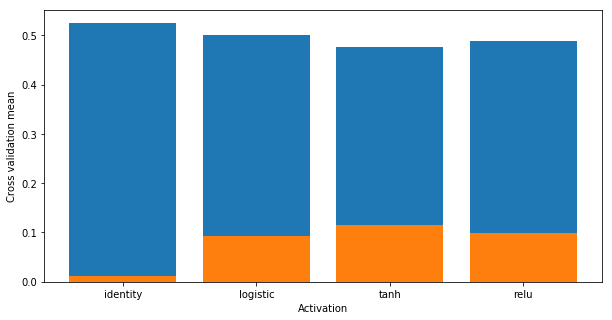

In [75]:
activation = ['identity', 'logistic', 'tanh', 'relu']

plt.figure(figsize=(10,5))
plt.bar(activation, cross_val_mean)
plt.bar(activation, cross_val_std)
plt.xlabel('Activation')
plt.ylabel('Cross validation mean')
plt.show()

PCA helped combat overfitting but still gave a relatively low r squared value

In [85]:
layer_mean=[]
layer_std=[]

for num in [100,200,300,400,500,600,700,800,900,1000]:
    mlpPCA = MLPClassifier(hidden_layer_sizes=(num,4),activation='identity')
    mlpPCA.fit(new_x,Y)
    mlpScore = cross_val_score(mlpPCA,new_x,Y, cv=5)
    layer_mean.append(np.mean(mlpScore))
    layer_std.append(np.std(mlpScore))

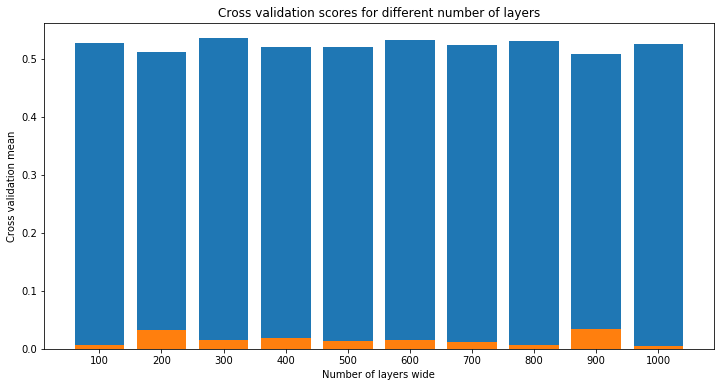

In [87]:
plt.figure(figsize=(12,6))
plt.bar(['100','200','300','400','500','600','700','800','900','1000'], layer_mean)
plt.bar(['100','200','300','400','500','600','700','800','900','1000'], layer_std)
plt.xlabel('Number of layers wide')
plt.ylabel('Cross validation mean')
plt.title('Cross validation scores for different number of layers')
plt.show()